Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание данных:**  

***Признаки***
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

***Целевой признак***
- Price — цена (евро)

<a id="glava_1"></a>
# Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [4]:
df.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

При проведении анализа признаков, можно отметить, что не все значения влияют на целевой признак.  
Для дальнейшей работы будут использоваться только следующие столбцы:
- 'Price', 
- 'VehicleType', 
- 'RegistrationYear', 
- 'Gearbox',
- 'Power', 
- 'Model', 
- 'Kilometer',  
- 'FuelType', 
- 'Brand',
- 'NotRepaired'.

In [6]:
df_new = df[['Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'FuelType', 'Brand',
       'NotRepaired']].copy()

In [7]:
df_new.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


**Проведем дальнейший анализ каждого признака**

In [8]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
Price               354369 non-null int64
VehicleType         316879 non-null object
RegistrationYear    354369 non-null int64
Gearbox             334536 non-null object
Power               354369 non-null int64
Model               334664 non-null object
Kilometer           354369 non-null int64
FuelType            321474 non-null object
Brand               354369 non-null object
NotRepaired         283215 non-null object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


In [9]:
df_new.describe()

,Price,RegistrationYear,Power,Kilometer
count,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535
std,4514.158514,90.227958,189.850405,37905.341530
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


In [10]:
df_new.isna().mean()

Price               0.000000
VehicleType         0.105794
RegistrationYear    0.000000
Gearbox             0.055967
Power               0.000000
Model               0.055606
Kilometer           0.000000
FuelType            0.092827
Brand               0.000000
NotRepaired         0.200791
dtype: float64

Пропуски присутствуют в столбцах: VehicleType, Gearbox, Model, FuelType, NotRepaired.

Оценим количество уникальных значений для каждого столбца:

In [11]:
df_new.astype('object').describe(include='all').loc['unique', :]

Price               3731
VehicleType            8
RegistrationYear     151
Gearbox                2
Power                712
Model                250
Kilometer             13
FuelType               7
Brand                 40
NotRepaired            2
Name: unique, dtype: object

Построим графики распределения значений в целевом признаке:

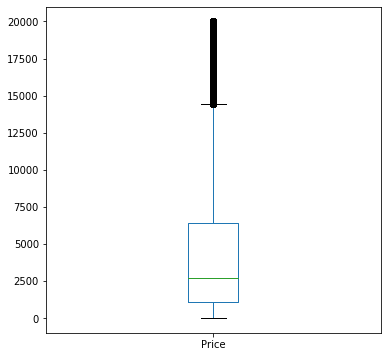

In [12]:
df_new['Price'].plot(kind='box', figsize=(6,6))

Значения целевой переменной начинаются с 0 и имеют выбросы при значениях больших 14000 евро.

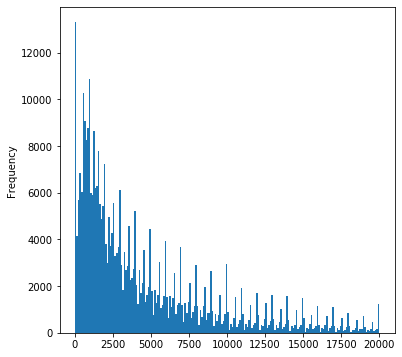

In [13]:
df_new['Price'].plot(kind='hist', bins=200, figsize=(6,6))

Для корректной работы модели, отбросим из данных значения меньше 0,05 квантиля и больших 0,95 квантиля:

In [14]:
df_new['Price'].quantile([.05, 0.95])

0.05      200.0
0.95    14600.0
Name: Price, dtype: float64

In [15]:
df_new = df_new.query('200 < Price < 14600').copy()

**Заполним пропуски в столбце** `['VehicleType']`.  

Для этого сгруппируем данные по марке автомобиля, найдем наиболее популярные типы кузова для каждой марки и заполним ими пропущенные значения.

In [16]:
df_new['VehicleType'].value_counts()

sedan          83487
small          74075
wagon          59475
bus            26545
convertible    17520
coupe          13466
suv             9405
other           2880
Name: VehicleType, dtype: int64

In [17]:
group_brand = df_new.groupby(['Brand', 'VehicleType']).agg({'Price':'count'}).rename(columns={"Price": "count"})

In [18]:
group_brand.head(10)

count
Brand      VehicleType       
alfa_romeo convertible    157
           coupe          219
           other           13
           sedan          870
           small          227
           wagon          437
audi       bus             10
           convertible   1286
           coupe          996
           other           99

In [19]:
brand = df_new['Brand'].unique()
brand

array(['volkswagen', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford', 'mazda',
       'renault', 'mercedes_benz', 'opel', 'seat', 'citroen', 'honda',
       'fiat', 'mini', 'smart', 'hyundai', 'audi', 'nissan', 'alfa_romeo',
       'subaru', 'volvo', 'mitsubishi', 'kia', 'suzuki', 'lancia',
       'toyota', 'chevrolet', 'dacia', 'sonstige_autos', 'daihatsu',
       'chrysler', 'jaguar', 'daewoo', 'rover', 'porsche', 'saab',
       'trabant', 'land_rover', 'lada'], dtype=object)

Создадим функцию `group_for_brand` по поиску наиболее популярных типов кузова:

In [20]:
# функция по созданию списока наиболее популярных типов кузова 
def group_for_brand(df, group_table, types):
    name_all = []
    brand_group = df.groupby([group_table, types]).agg({'Price':'count'}).rename(columns={"Price": "count"})
    for i in brand:
        name = brand_group.loc[i].nlargest(1, 'count').index[0]
        name_all.append(name)
    return name_all
    

Отобразим полученные данные в виде таблицы и сохраним в переменную `brand_of_VT`: 

In [21]:
vehicle_type = group_for_brand(df_new, 'Brand', 'VehicleType')

pd.DataFrame({'Brand':brand, 'VehicleType':vehicle_type})

,Brand,VehicleType
0,volkswagen,sedan
1,jeep,suv
2,skoda,wagon
3,bmw,sedan
4,peugeot,small
5,ford,small
6,mazda,sedan
7,renault,small
8,mercedes_benz,sedan
9,opel,small


In [22]:
brand_of_VT = pd.DataFrame({'Brand':brand, 'VehicleType':vehicle_type})

Создадим таблицу с пропущенными знаечниями `['VehicleType']` и новой колонкой с наиболее популярными типами кузова:

In [23]:
merge_VT = df_new[df_new['VehicleType'].isna()].merge(brand_of_VT, on='Brand', how='outer')
merge_VT.head()

,Price,VehicleType_x,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,VehicleType_y
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,sedan
1,300,NaN,2016,NaN,60,polo,150000,petrol,volkswagen,NaN,sedan
2,350,NaN,2016,manual,75,golf,150000,petrol,volkswagen,no,sedan
3,7750,NaN,2017,manual,80,golf,100000,petrol,volkswagen,NaN,sedan
4,800,NaN,2000,manual,90,golf,150000,gasoline,volkswagen,NaN,sedan


In [24]:
df_new = df_new.merge(merge_VT, how='left').copy()

В столбце `['VehicleType']` заменим пропуски на значения "0" для дальнейшего заполнения:

In [25]:
df_new['VehicleType'] = df_new['VehicleType'].fillna(0)

Создадим функцию `nan_row` для подстановки значений в столбец `['VehicleType']` и проведем слияние:

In [26]:
def nan_row(row):
    if row['VehicleType'] == 0:
        return row['VehicleType_y']
    else:
        return row['VehicleType']

In [27]:
df_new['VehicleType_pred'] = df_new.apply(nan_row, axis=1)
df_new['VehicleType'] = df_new['VehicleType_pred']

Удалим лишние столбцы, полученные после объединения таблиц:

In [28]:
df_new = df_new.drop(['VehicleType_x', 'VehicleType_y', 'VehicleType_pred'], axis=1).copy()

In [29]:
df_new.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,sedan,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
2,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
3,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
4,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


In [30]:
df_new.isna().mean()

Price               0.000000
VehicleType         0.000000
RegistrationYear    0.000000
Gearbox             0.050947
Power               0.000000
Model               0.051578
Kilometer           0.000000
FuelType            0.087743
Brand               0.000000
NotRepaired         0.196754
dtype: float64

**Изучим данные в столбце** `['RegistrationYear']`

In [31]:
df_new['RegistrationYear'].describe()

count    321940.000000
mean       2003.799053
std          66.451513
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

В датах регистрации автомобилей пристутствуют некорректные значения.

Выведем самую новую дату загрузки анкеты:

In [32]:
df['DateCrawled'].max()

'2016-04-07 14:36:58'

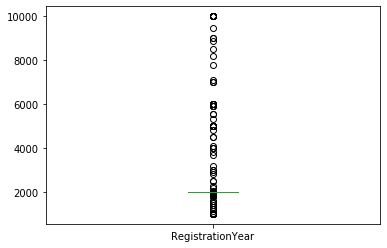

In [33]:
df_new['RegistrationYear'].plot(kind='box')

Самый старый [автомобиль](https://lenta.ru/news/2011/10/09/oldest/) выставленный на продажу произведен в 1884 году, а данные содержат информацию об автомобилях до 2016 года, следовательно можно отбросить значения вне этого диапазона.

In [34]:
df_new = df_new.query('1884 <= RegistrationYear <= 2016').copy()

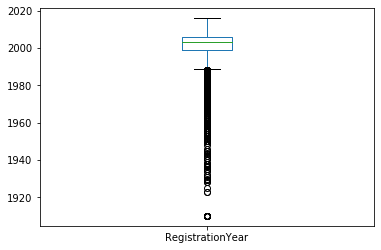

In [35]:
df_new['RegistrationYear'].plot(kind='box')

Как мы видим на гафике много выбросов до 1990 года, отбросим и эти значения:

In [36]:
df_new = df_new.query('1990 <= RegistrationYear <= 2016')

**Заполним пропуски в столбце** `['Gearbox']`.  

Примем, что пропущенные значения равны значению **manual**:

In [37]:
df_new['Gearbox'] = df_new['Gearbox'].fillna('manual').copy()

**Изучим данные в столбце** `['Power']`

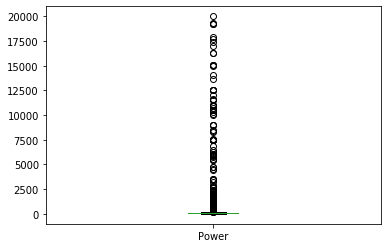

In [38]:
df_new['Power'].plot(kind='box')

In [39]:
df_new['Power'].quantile([0.05, 0.99])

0.05      0.0
0.99    280.0
Name: Power, dtype: float64

Отбросим значения меньше 0,05 квантиля и большие 0,95:

In [40]:
df_new = df_new.query('0 <= Power <= 300')

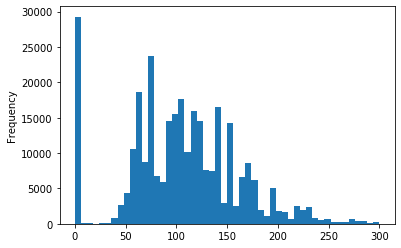

In [41]:
df_new['Power'].plot(kind='hist',bins=50)

Количество значений равных нулю в данной метрике очень много, а его влияние на конечную стоимость автомобиля отрицать нельзя.  

Поэтому выполним замену нулевых значений средней мощностью для каждого типа кузова автомобиля:

In [42]:
df_new[df_new['Power'] == 0].head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,sedan,1993,manual,0,golf,150000,petrol,volkswagen,NaN
29,245,sedan,1994,manual,0,golf,150000,petrol,volkswagen,no
34,1500,small,2016,manual,0,kangoo,150000,gasoline,renault,no
49,4700,wagon,2005,manual,0,signum,150000,NaN,opel,no
50,550,wagon,1999,manual,0,astra,150000,gasoline,opel,yes


In [43]:
df_new.groupby(['VehicleType']).agg({'Power':'mean'})

,Power
VehicleType,
bus,108.015110
convertible,124.129357
coupe,141.202275
other,82.855095
sedan,114.052521
small,64.538163
suv,143.730979
wagon,126.883978


In [44]:
group_vehicletype = df_new.groupby(['VehicleType'])

In [45]:
df_new['Power'] = df_new['Power'].replace(0, np.nan).copy()

In [46]:
df_new['Power'] = group_vehicletype['Power'].apply(lambda x: x.fillna(x.mean())).round()

In [47]:
df_new['Power'][df_new['Power'] == 0].count()

0

In [48]:
df_new['Power'].quantile([0.01, 0.99])

0.01     45.0
0.99    250.0
Name: Power, dtype: float64

Отбросим значения меньшие 45 л.с. и большие 250 л.с.

In [49]:
df_new = df_new.query('45 <= Power <= 250').copy()

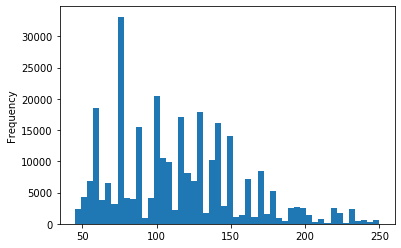

In [50]:
df_new['Power'].plot(kind='hist',bins=50)

**Заполним пропуски в столбце** `['Model']` на значение **unknown**

In [51]:
df_new['Model'] = df_new['Model'].fillna('unknown')

**Изучим данные в столбце** `['Kilometer']`

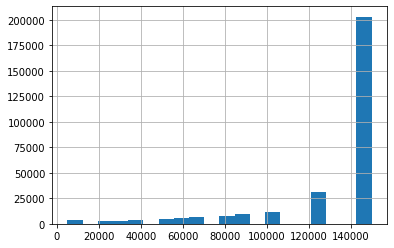

In [52]:
df_new['Kilometer'].hist(bins=20)

Как видно из гистограммы большая часть автомобилей продается с пробегом более 140000 км. Аномалий в значениях нет, поэтому данную метрику оставим без изменений.

In [53]:
df_new.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,sedan,1993,manual,128.0,golf,150000,petrol,volkswagen,NaN
1,9800,suv,2004,auto,163.0,grand,125000,gasoline,jeep,NaN
2,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no
3,3600,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no
4,650,sedan,1995,manual,102.0,3er,150000,petrol,bmw,yes


**Заменим пропуски в столбце** `['FuelType']` на значение **unknown**:

In [54]:
df_new['FuelType'] = df_new['FuelType'].fillna('unknown').copy()

**Заменим пропуски в столбце** `['NotRepaired']` на значение **no**, как из наиболее чаще встречающееся:

In [55]:
df_new['NotRepaired'].value_counts()

no     210321
yes     28625
Name: NotRepaired, dtype: int64

In [56]:
df_new['NotRepaired'] = df_new['NotRepaired'].fillna('no').copy()

In [57]:
df_new.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,sedan,1993,manual,128.0,golf,150000,petrol,volkswagen,no
1,9800,suv,2004,auto,163.0,grand,125000,gasoline,jeep,no
2,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no
3,3600,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no
4,650,sedan,1995,manual,102.0,3er,150000,petrol,bmw,yes


In [58]:
df_new.isna().mean()

Price               0.0
VehicleType         0.0
RegistrationYear    0.0
Gearbox             0.0
Power               0.0
Model               0.0
Kilometer           0.0
FuelType            0.0
Brand               0.0
NotRepaired         0.0
dtype: float64

In [59]:
corr_matrix = df_new.corr()

In [60]:
corr_matrix['Price'].sort_values(ascending=False)

Price               1.000000
RegistrationYear    0.570135
Power               0.445278
Kilometer          -0.332439
Name: Price, dtype: float64

In [61]:
df_new.shape

(292248, 10)

In [62]:
df.shape

(354369, 16)

In [63]:
data_loss = df.shape[0] / df_new.shape[0] - 1
print('Процент потерь данных: {:.1%}'.format(data_loss))

Процент потерь данных: 21.3%


## Вывод

В таблице с данными содержится 354369 строк и 16 столбцов.  

Для построения моделей будут использоваться следующие виды метрик:
`'Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model', 'Kilometer', 'FuelType', 'Brand', 'NotRepaired'.`  

Пропуски присутствуют в столбцах: `'VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired'.` 

Проведены следующие преобразования:
1. Значения в целевом признаке(Цена) лежат в следующих пределах - **'200 < Price < 14600'**,
2. Заполнены пропуски в столбце `['VehicleType']` **наиболее популярным типом кузова** для каждой марки,
3. Дата регистрации автомобиля находится в диапазоне - **'1990 <= RegistrationYear <= 2016'**,
4. Заполнены пропуски в столбце `['Gearbox']` и равны значению **manual**
5. Заменены нулевых значений средней мощностью для каждого типа кузова автомобиля, значения в диапазоне **'45 <= Power <= 250'**, 
6. Заполнены пропуски в столбце `['Model']` на значение **unknown**
7. Заполнены пропуски в столбце `['FuelType']` на значение **unknown**
8. Заполнены  пропуски в столбце `['NotRepaired']` на значение **no**  


Процент потерь данных: 21.3%

<a id="glava_2"></a>
# Обучение моделей

Так как целевой признак является непрерывной величиной, будем решать задачу регрессии.  

Используем следующие виды моделей:
1. LinearRegression
2. RandomForestRegressor
3. CatBoost
4. LGBMRegressor

Для оценки качества моделей будем применять метрику RMSE.

Выделим из данных целевой признак и отделим 20% данных для тестовой выборки:

In [64]:
features = df_new.drop(['Price'], axis=1)
target = df_new['Price']

In [65]:
# отделим 20% данных для тестовой выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.20, random_state=12345)

In [66]:
print(features.shape)
print(features_train.shape)
print(features_test.shape)

(292248, 9)
(233798, 9)
(58450, 9)


In [67]:
features_train.shape[0] + features_test.shape[0]

292248

## One-Hot Encoding

В таблице с данными пристутствует много категориальных признаков. 

Применим технику one-hot-encoding для кодирования категориальных данных.

Удалим столбцы с большим количеством категориальных значений и закодируем данные для обучающей и тестовой выборки:

In [68]:
features_train = features_train.drop(['Model','Brand'], axis=1).copy()

In [69]:
features_test = features_test.drop(['Model','Brand'], axis=1).copy()

In [70]:
ohe_features_train = pd.get_dummies(features_train, drop_first=True)

In [71]:
ohe_features_test = pd.get_dummies(features_test, drop_first=True)

In [72]:
features_train.head()

,VehicleType,RegistrationYear,Gearbox,Power,Kilometer,FuelType,NotRepaired
130950,small,1998,manual,65.0,150000,petrol,no
221251,sedan,1998,manual,95.0,125000,unknown,no
43601,small,2010,manual,74.0,60000,petrol,no
159038,sedan,2004,manual,140.0,150000,gasoline,no
145485,small,2000,manual,58.0,150000,unknown,no


In [73]:
ohe_features_train.head()

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,FuelType_unknown,NotRepaired_yes
130950,1998,65.0,150000,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
221251,1998,95.0,125000,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0
43601,2010,74.0,60000,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
159038,2004,140.0,150000,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0
145485,2000,58.0,150000,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0


In [74]:
state = np.random.RandomState(12345)

## LinearRegression

Обучим модель линейной регрессии и оценим качество модели кросс-валидацией функция `cross_val_score`.

In [75]:
%%time
lr = LinearRegression(normalize=True)
scores_lr = cross_val_score(lr, ohe_features_train, target_train, 
                              scoring='neg_mean_squared_error', cv=3)
rmse_scores_lr = (np.sqrt(-scores_lr)).mean()
print('Среднее значение RMSE при кросс-валидации LinearRegression =', rmse_scores_lr)

Среднее значение RMSE при кросс-валидации LinearRegression = 2199.9553446427526
CPU times: user 680 ms, sys: 488 ms, total: 1.17 s
Wall time: 1.14 s


## RandomForestRegressor

Проведем обучение модели случайный лес с подбором гиперпараметров и оценкой кросс-валидацией:

In [76]:
%%time
param_grid = [
    {'n_estimators': [100, 200],
    'max_features': [8, 10]}    
]
rfr = RandomForestRegressor(random_state=state)
grid_search = GridSearchCV(rfr, param_grid, cv=3,
                          scoring='neg_mean_squared_error')
grid_search.fit(ohe_features_train, target_train)
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)
best = grid_search.best_params_
print(grid_search.best_params_)

1486.3191912476118 {'max_features': 8, 'n_estimators': 100}
1485.0791047026983 {'max_features': 8, 'n_estimators': 200}
1487.16327421548 {'max_features': 10, 'n_estimators': 100}
1485.2614973176596 {'max_features': 10, 'n_estimators': 200}
{'max_features': 8, 'n_estimators': 200}
CPU times: user 9min 32s, sys: 8.75 s, total: 9min 40s
Wall time: 9min 45s


## CatBoost

Обучим модель CatBoost и оценим результаты кросс-валидацией. Известно, что CatBoost отлично справляется с категориальными переменными, а на закодированных данных зачастую показывает худший результат предсказаний.  
Используем при обучении модели оригинальные данные.

In [77]:
cat_features = ['VehicleType', 'FuelType', 'Gearbox', 'NotRepaired']

In [78]:
%%time
cbr = CatBoostRegressor(learning_rate=0.5,
                        random_state=12345,
                        cat_features=cat_features,
                        verbose=200, 
                       iterations=600,
                       early_stopping_rounds=400) 
scores_cbr = cross_val_score(cbr, features_train, target_train, 
                              scoring='neg_mean_squared_error', cv=3)
rmse_scores_cbr = (np.sqrt(-scores_cbr)).mean()
print('Среднее значение RMSE при кросс-валидации LinearRegression =', rmse_scores_cbr)

0:	learn: 2483.7338695	total: 363ms	remaining: 3m 37s
200:	learn: 1445.9709075	total: 55.2s	remaining: 1m 49s
400:	learn: 1409.1159211	total: 1m 48s	remaining: 53.9s
599:	learn: 1387.3603493	total: 2m 41s	remaining: 0us
0:	learn: 2475.8907101	total: 266ms	remaining: 2m 39s
200:	learn: 1444.4349471	total: 55s	remaining: 1m 49s
400:	learn: 1404.8537958	total: 1m 48s	remaining: 53.8s
599:	learn: 1382.8025667	total: 2m 40s	remaining: 0us
0:	learn: 2492.6553980	total: 245ms	remaining: 2m 26s
200:	learn: 1450.8593085	total: 54.4s	remaining: 1m 48s
400:	learn: 1409.1937553	total: 1m 47s	remaining: 53.5s
599:	learn: 1386.3876671	total: 2m 40s	remaining: 0us
Среднее значение RMSE при кросс-валидации LinearRegression = 1466.143513932643
CPU times: user 6min 54s, sys: 1min 12s, total: 8min 6s
Wall time: 8min 19s


## LGBMRegressor

Обучим модель Light Gradient Boosted Machine с подбором гиперпараметров и проверкой кросс-валидацией:

In [79]:
model_lgbmr = LGBMRegressor(random_state=state)
param_grid = [
    {'num_leaves': [50, 100, 300],
    'max_depth':[4, 8, 10], 
    'random_state':[12345]}
]

In [80]:
%%time
grid_search = GridSearchCV(model_lgbmr, param_grid, cv=3,
                          scoring='neg_mean_squared_error')
grid_search.fit(ohe_features_train, target_train)
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)
best = grid_search.best_params_
print(grid_search.best_params_)


1591.042932202335 {'max_depth': 4, 'num_leaves': 50, 'random_state': 12345}
1591.042932202335 {'max_depth': 4, 'num_leaves': 100, 'random_state': 12345}
1591.042932202335 {'max_depth': 4, 'num_leaves': 300, 'random_state': 12345}
1510.6225471415605 {'max_depth': 8, 'num_leaves': 50, 'random_state': 12345}
1486.8724996261105 {'max_depth': 8, 'num_leaves': 100, 'random_state': 12345}
1481.059051211846 {'max_depth': 8, 'num_leaves': 300, 'random_state': 12345}
1506.8891673798046 {'max_depth': 10, 'num_leaves': 50, 'random_state': 12345}
1479.2397036675147 {'max_depth': 10, 'num_leaves': 100, 'random_state': 12345}
1459.0331795605466 {'max_depth': 10, 'num_leaves': 300, 'random_state': 12345}
{'max_depth': 10, 'num_leaves': 300, 'random_state': 12345}
CPU times: user 5min 13s, sys: 1.93 s, total: 5min 15s
Wall time: 5min 19s


## Вывод

Категориальные признаки закодированы методом One-Hot Encoding.  
Выполнено обучение 4 различных моделей, подобраны гиперпараметры.

<a id="glava_3"></a>
# Анализ моделей

Проведем анализ моделей на тестовых выборках, оценим скорость работы и точность результата.

## LinearRegression

In [81]:
%%time
lr = LinearRegression(normalize=True)
lr.fit(ohe_features_train, target_train)
target_predict = lr.predict(ohe_features_test)
rmse_lr_test = np.sqrt(mean_squared_error(target_test, target_predict))
rmse_lr_test

CPU times: user 252 ms, sys: 101 ms, total: 353 ms
Wall time: 393 ms


2212.1222671768905

## RandomForestRegressor

In [82]:
%%time
rfr = RandomForestRegressor(random_state=state, max_features=8, n_estimators=200)
rfr.fit(ohe_features_train, target_train)
target_predict = rfr.predict(ohe_features_test)
rmse_rfr_test = np.sqrt(mean_squared_error(target_test, target_predict))
rmse_rfr_test

CPU times: user 1min 14s, sys: 789 ms, total: 1min 15s
Wall time: 1min 15s


1466.5070551596716

## CatBoost

In [83]:
%%time
cbr = CatBoostRegressor(learning_rate=0.5,
                        random_state=12345,
                        cat_features=cat_features,
                        verbose=200, 
                       iterations=600,
                       early_stopping_rounds=400)
cbr.fit(features_train, target_train)
target_predict = cbr.predict(features_test)
rmse_cbr_test = np.sqrt(mean_squared_error(target_test, target_predict))
rmse_cbr_test

0:	learn: 2535.1616108	total: 417ms	remaining: 4m 9s
200:	learn: 1453.1217160	total: 1m 18s	remaining: 2m 35s
400:	learn: 1415.7873414	total: 2m 38s	remaining: 1m 18s
599:	learn: 1396.5884357	total: 3m 54s	remaining: 0us
CPU times: user 3min 17s, sys: 37.5 s, total: 3min 55s
Wall time: 3min 59s


1465.0183305290952

## LGBMRegressor

In [84]:
%%time
model_lgbmr = LGBMRegressor(max_depth=10, num_leaves=300, random_state=12345)
model_lgbmr.fit(ohe_features_train, target_train)
target_predict = model_lgbmr.predict(ohe_features_test)
rmse_gbmr_test = np.sqrt(mean_squared_error(target_test, target_predict))
rmse_gbmr_test

CPU times: user 21.3 s, sys: 206 ms, total: 21.5 s
Wall time: 21.7 s


1461.2223317404435

In [85]:
model_lgbmr.feature_importances_

array([5792, 8843, 3332,  605,  375,   99,  832,  426,  465,  654, 1077,
         17,  928,   32,  125,   12,  687,  314,  873], dtype=int32)

In [86]:
feature_lgbmr = pd.DataFrame(sorted(zip(model_lgbmr.feature_importances_,ohe_features_train.columns)), columns=['Value','Feature'])
feature_lgbmr = feature_lgbmr.sort_values(by="Value", ascending=False).copy()
feature_lgbmr

,Value,Feature
18,8843,Power
17,5792,RegistrationYear
16,3332,Kilometer
15,1077,Gearbox_manual
14,928,FuelType_gasoline
13,873,NotRepaired_yes
12,832,VehicleType_sedan
11,687,FuelType_petrol
10,654,VehicleType_wagon
9,605,VehicleType_convertible


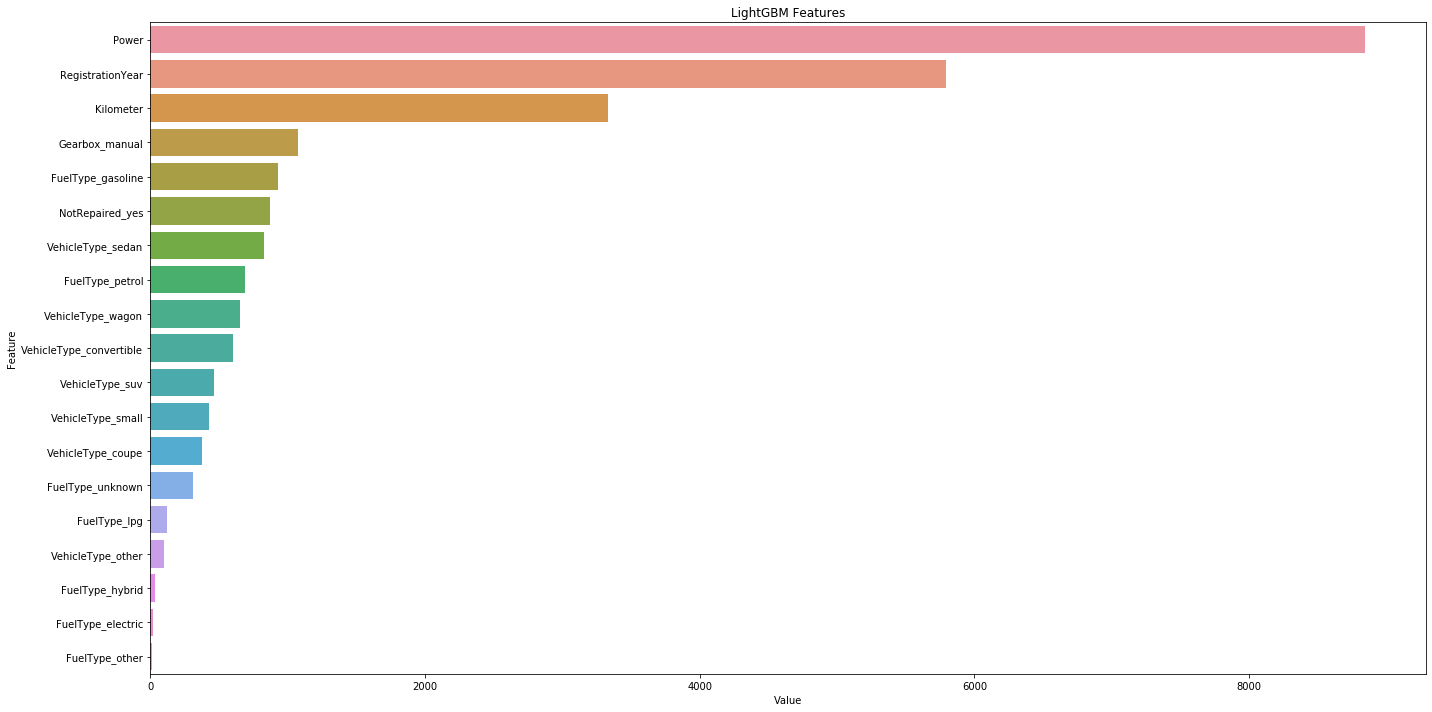

In [87]:
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_lgbmr)
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

Сгруппируем результаты анализа моделей.  
Выставим ранги по времени обучения и точности результата.

In [88]:
data_training = {'time_training_sec':['0.31', '67', '239', '22'], 
        'RMSE': [rmse_lr_test.round(), rmse_rfr_test.round(), rmse_cbr_test.round(), rmse_gbmr_test.round()]}
index = ['LinearRegression', 'RandomForestRegressor', 'CatBoost', 'LGBMRegressor']
model_analysis = pd.DataFrame(data_training, index=index)
model_analysis['rank_time'] = model_analysis['time_training_sec'].rank(na_option='bottom')
model_analysis['rank_RMSE'] = model_analysis['RMSE'].rank(na_option='bottom')
model_analysis['rank_final'] = (model_analysis['rank_time'] + model_analysis['rank_RMSE']).rank(na_option='bottom')
model_analysis = model_analysis.sort_values(by='rank_final', ascending=True)
model_analysis

,time_training_sec,RMSE,rank_time,rank_RMSE,rank_final
LGBMRegressor,22,1461.0,2.0,1.0,1.0
LinearRegression,0.31,2212.0,1.0,4.0,2.5
CatBoost,239,1465.0,3.0,2.0,2.5
RandomForestRegressor,67,1467.0,4.0,3.0,4.0


<a id="conclusion"></a>
# Вывод

В таблице с данными содержится 354369 строк и 16 столбцов.  

Для построения моделей будут используются следующие виды метрик:
`'Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model', 'Kilometer', 'FuelType', 'Brand', 'NotRepaired'.`  

Процент потерь данных после предобработки данных: **21.3%**.

Анализируются следующие виды моделей:
1. LinearRegression
2. RandomForestRegressor
3. CatBoost
4. LGBMRegressor

Для оценки качества моделей применяется метрика RMSE.  

Категориальные признаки закодированы методом One-Hot Encoding.  


| Tables        | time_training_sec| RMSE  | rank_time | rank_RMSE | rank_final |
| ------------- |------------------| ----- |-----------|-----------|------------|
| LGBMRegressor |22| 1461 |2|1|1|
| LinearRegression |0.31| 2212 |2|4|2.5|
| CatBoost |239| 1465 |3|2|2.5|
| RandomForestRegressor |67| 1467 |4|3|4|

**Анализ моделей:**  
1. LinearRegression:
    - худший результат метрики RMSE,
    - очень высокая скорость предсказания,
    - требуется кодирование категориальных переменных.
2. RandomForestRegressor:
    - хороший результат метрики RMSE,
    - низкая скорость предсказания,
    - требуется кодирование категориальных переменных.
3. CatBoost:
    - высокий результат метрики RMSE,
    - крайне низкая скорость предсказания,
    - не требует кодирование категориальных переменных.
4. LGBMRegressor:
    - лучший результат метрики RMSE,
    - высокая скорость предсказания,
    - требуется кодирование категориальных переменных.

Для обеспечения скорости работы и точности результата, наиболее оптимальным выбором быдет использование модели - **LGBMRegressor**, но с обязательной процедурой кодирования категориальных переменных.  